In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as spa

import hylife.utilitis_FEEC.bsplines     as bsp
import hylife.utilitis_FEEC.Bspline      as bspline
import hylife.utilitis_FEEC.spline_space as spl
import hylife.utilitis_FEEC.derivatives  as der

import hylife.utilitis_FEEC.projectors.projectors_global as proj_global
import hylife.utilitis_FEEC.projectors.projectors_local  as proj_local

import hylife.utilitis_FEEC.basics.mass_matrices_1d  as mass
import hylife.utilitis_FEEC.basics.inner_products_1d as inner
import hylife.utilitis_FEEC.basics.l2_error_1d       as l2

# 1. Convergence of projector $\Pi_0$

In [19]:
test_fun = lambda x : np.sin(2*np.pi*x)                    # function we want to project
xplot  = np.linspace(0., 1., 200)                 

Nels   = np.array([4, 8, 16, 32, 64, 128, 256, 512, 1024])   # number of elements
ps     = np.array([2, 3, 4])                                 # spline degrees

hs     = np.zeros((len(ps), len(Nels)))

errors_glob = np.zeros((len(ps), len(Nels)))       # L2 - error in V0 (global projector)
errors_loc  = np.zeros((len(ps), len(Nels)))       # L2 - error in V0 (local projector)



for ip in range(len(ps)):
    for ie in range(len(Nels)):

        Nel        = Nels[ie]                      # number of elements   
        bc         = True                          # boundary conditions (True: periodic, False: else)
        p          = int(ps[ip])                   # spline degres  

        el_b       = np.linspace(0., 1., Nel + 1)  # element boundaries
        T          = bsp.make_knots(el_b, p, bc)   # knot vector (for N functions)
        
        nq_el      = p + 1                         # number of quadrature points per element for integrations over whole domain
        nq_pr      = p + 1                         # number of quadrature points per integration interval for projectors
        
        # 1d B-spline finite element space
        space      = spl.spline_space_1d(T, p, bc, nq_el) 
        
        hs[ip, ie] = space.delta                   # element size
        t          = space.t                       # reduced knot vector (for D functions)
        NbaseN     = space.NbaseN                  # number of basis functions (N functions)
        NbaseD     = space.NbaseD                  # number of basis functions (D functions)
        
        
        # projector
        proj_glob = proj_global.projectors_1d(T, p, bc)
        proj_loc  = proj_local.projectors_local_1d(space, nq_pr)

        # assemble interpolation matrix for global projector (not needed for local one)
        proj_glob.assemble_V0()
        
        coeff_glob = proj_glob.PI_0(test_fun)
        coeff_loc  = proj_loc.pi_0(test_fun)
        
        errors_glob[ip, ie] = l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff_glob, test_fun)
        errors_loc[ip, ie] = l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff_loc, test_fun)

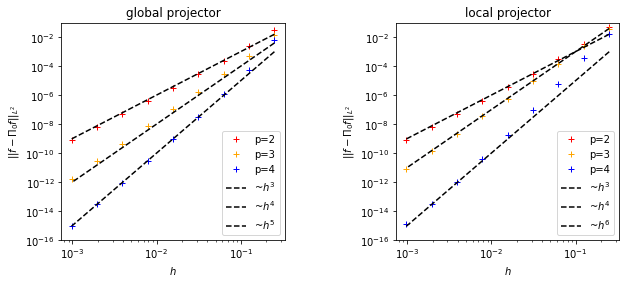

In [20]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(4)


plt.subplot(1, 2, 1)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_glob[ip], 'k+', color=colors[ip], label=labels[ip])
    
plt.loglog(hs[0], hs[0]**3, 'k--', label='~$h^3$')
plt.loglog(hs[0], hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], hs[0]**5, 'k--', label='~$h^5$')



plt.xlabel('$h$')
plt.ylabel('$||f-\Pi_0f||_{L^2}$')
plt.title('global projector')
plt.ylim((1e-16, 1e-1))
plt.legend()


plt.subplot(1, 2, 2)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_loc[ip], 'k+', color=colors[ip], label=labels[ip])

plt.loglog(hs[0],     hs[0]**3, 'k--', label='~$h^3$')
plt.loglog(hs[0], 1e1*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 1e0*hs[0]**5, 'k--', label='~$h^6$')

plt.xlabel('$h$')
plt.ylabel('$||f-\Pi_0f||_{L^2}$')
plt.title('local projector')
plt.ylim((1e-16, 1e-1))
plt.legend()

plt.subplots_adjust(wspace=0.5)

# 2. Convergence of projector $\Pi_1$

In [21]:
test_fun = lambda x : np.sin(2*np.pi*x)                    # function we want to project
xplot  = np.linspace(0., 1., 200)                 

Nels   = np.array([4, 8, 16, 32, 64, 128, 256, 512, 1024])   # number of elements
ps     = np.array([2, 3, 4])                                 # spline degrees

hs     = np.zeros((len(ps), len(Nels)))

errors_glob = np.zeros((len(ps), len(Nels)))       # L2 - error in V1 (global projector)
errors_loc  = np.zeros((len(ps), len(Nels)))       # L2 - error in V1 (local projector)


for ip in range(len(ps)):
    for ie in range(len(Nels)):

        Nel        = Nels[ie]                      # number of elements   
        bc         = True                          # boundary conditions (True: periodic, False: else)
        p          = int(ps[ip])                   # spline degres  

        el_b       = np.linspace(0., 1., Nel + 1)  # element boundaries
        T          = bsp.make_knots(el_b, p, bc)   # knot vector (for N functions)
        
        nq_el      = p + 1                         # number of quadrature points per element for integrations over whole domain
        nq_pr      = p + 1                         # number of quadrature points per integration interval for projectors
        
        # 1d B-spline finite element space
        space      = spl.spline_space_1d(T, p, bc, nq_el) 
        
        hs[ip, ie] = space.delta                   # element size
        t          = space.t                       # reduced knot vector (for D functions)
        NbaseN     = space.NbaseN                  # number of basis functions (N functions)
        NbaseD     = space.NbaseD                  # number of basis functions (D functions)
        
        
        # projector
        proj_glob = proj_global.projectors_1d(T, p, bc)
        proj_loc  = proj_local.projectors_local_1d(space, nq_pr)

        # assemble histopolation matrix for global projector (not needed for local one)
        proj_glob.assemble_V1()
        
        coeff_glob = proj_glob.PI_1(test_fun)
        coeff_loc  = proj_loc.pi_1(test_fun)
        
        errors_glob[ip, ie] = l2.l2_error_V1(space, lambda x : np.ones(x.shape), coeff_glob, test_fun)
        errors_loc[ip, ie] = l2.l2_error_V1(space, lambda x : np.ones(x.shape), coeff_loc, test_fun)

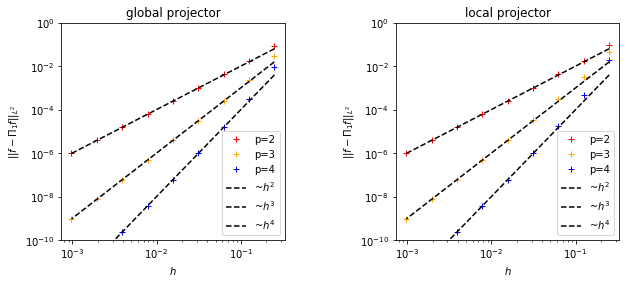

In [22]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(4)


plt.subplot(1, 2, 1)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_glob[ip], 'k+', color=colors[ip], label=labels[ip])
  
    
plt.loglog(hs[0], hs[0]**2, 'k--', label='~$h^2$')
plt.loglog(hs[0], hs[0]**3, 'k--', label='~$h^3$')
plt.loglog(hs[0], hs[0]**4, 'k--', label='~$h^4$')

plt.xlabel('$h$')
plt.ylabel('$||f-\Pi_1f||_{L^2}$')
plt.title('global projector')
plt.ylim((1e-10, 1e0))
plt.legend()


plt.subplot(1, 2, 2)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_loc[ip], 'k+', color=colors[ip], label=labels[ip])

plt.loglog(hs[0], hs[0]**2, 'k--', label='~$h^2$')
plt.loglog(hs[0], hs[0]**3, 'k--', label='~$h^3$')
plt.loglog(hs[0], hs[0]**4, 'k--', label='~$h^4$')

plt.xlabel('$h$')
plt.ylabel('$||f-\Pi_1f||_{L^2}$')
plt.title('local projector')
plt.ylim((1e-10, 1e0))
plt.legend()

plt.subplots_adjust(wspace=0.5)

# 3. Commutativity $\Pi_1(\mathrm{d}f/\mathrm{d}x)=\mathrm{d}(\Pi_0f)/\mathrm{d}x$

In [23]:
test_fun  = lambda x : np.sin(2*np.pi*x)           # function we want to project
dtest_fun = lambda x : np.cos(2*np.pi*x)*2*np.pi   # its derivative

xplot  = np.linspace(0., 1., 200)                 

Nels   = np.array([4, 8, 16, 32, 64, 128, 256, 512])   # number of elements
ps     = np.array([2, 3, 4])                                 # spline degrees

hs     = np.zeros((len(ps), len(Nels)))

errors_glob = np.zeros((len(ps), len(Nels)))       # L2 - error in V1 (global projector)
errors_loc  = np.zeros((len(ps), len(Nels)))       # L2 - error in V1 (local projector)

for ip in range(len(ps)):
    for ie in range(len(Nels)):

        Nel        = Nels[ie]                      # number of elements   
        bc         = True                          # boundary conditions (True: periodic, False: else)
        p          = int(ps[ip])                   # spline degres  

        el_b       = np.linspace(0., 1., Nel + 1)  # element boundaries
        T          = bsp.make_knots(el_b, p, bc)   # knot vector (for N functions)
        
        nq_el      = p + 1                         # number of quadrature points per element for integrations over whole domain
        nq_pr      = p + 1                         # number of quadrature points per integration interval for projectors
        
        # 1d B-spline finite element space
        space      = spl.spline_space_1d(T, p, bc, nq_el) 
        
        hs[ip, ie] = space.delta                   # element size
        t          = space.t                       # reduced knot vector (for D functions)
        NbaseN     = space.NbaseN                  # number of basis functions (N functions)
        NbaseD     = space.NbaseD                  # number of basis functions (D functions)
        
        grad       = der.grad_1d(space)        # discrete derivative
        
        
        # projector
        proj_glob = proj_global.projectors_1d(T, p, bc)
        proj_loc  = proj_local.projectors_local_1d(space, nq_pr)
        
        # assemble interpolation/histopolation matrix for global projector (not needed for local one)
        proj_glob.assemble_V0()
        proj_glob.assemble_V1()
        
        lhs_glob = proj_glob.PI_1(dtest_fun)
        lhs_loc  = proj_loc.pi_1(dtest_fun)
        
        rhs_glob = grad.dot(proj_glob.PI_0(test_fun))
        rhs_loc  = grad.dot(proj_loc.pi_0(test_fun))
        
        errors_glob[ip, ie] = l2.l2_error_V1(space, lambda x : np.ones(x.shape), lhs_glob - rhs_glob, lambda x : 0*x)
        errors_loc[ip, ie] = l2.l2_error_V1(space, lambda x : np.ones(x.shape), lhs_loc - rhs_loc, lambda x : 0*x)

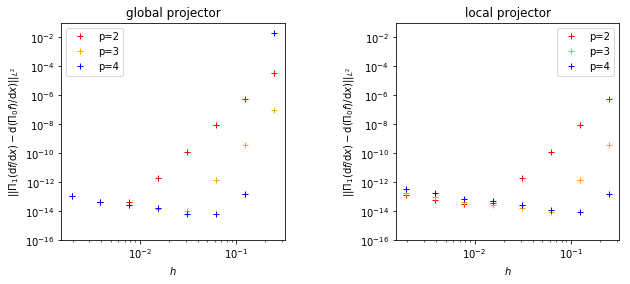

In [24]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(4)


plt.subplot(1, 2, 1)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_glob[ip], 'k+', color=colors[ip], label=labels[ip])



plt.xlabel('$h$')
plt.ylabel('$||\Pi_1(\mathrm{d}f/\mathrm{d}x) - \mathrm{d}(\Pi_0f)/\mathrm{d}x)||_{L^2}$')
plt.title('global projector')
plt.ylim((1e-16, 1e-1))
plt.legend()


plt.subplot(1, 2, 2)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_loc[ip], 'k+', color=colors[ip], label=labels[ip])


plt.xlabel('$h$')
plt.ylabel('$||\Pi_1(\mathrm{d}f/\mathrm{d}x) - \mathrm{d}(\Pi_0f)/\mathrm{d}x)||_{L^2}$')
plt.title('local projector')
plt.ylim((1e-16, 1e-1))
plt.legend()

plt.subplots_adjust(wspace=0.5)

# 4. Convergence of projector $\Pi_0$ with intermediate projection on $V_1$

In [25]:
# now: test_fun lives in discrete space V1 and needs to be projected to V0 space
test_fun = lambda x : np.sin(2*np.pi*x)               # function we want to project

omega    = 1.
Beq      = lambda x : np.cos(omega*2*np.pi*x)         # background function which we mulitply in between

xplot  = np.linspace(0., 1., 200)                 

Nels   = np.array([8, 16, 32, 64, 128, 256, 512])   # number of elements
ps     = np.array([2, 3, 4, 5])                                 # spline degrees

hs     = np.zeros((len(ps), len(Nels)))

errors_glob = np.zeros((len(ps), len(Nels)))       # L2 - error in V0 (global projector)
errors_loc  = np.zeros((len(ps), len(Nels)))       # L2 - error in V0 (local projector)

for ip in range(len(ps)):
    for ie in range(len(Nels)):

        Nel        = Nels[ie]                      # number of elements   
        bc         = True                          # boundary conditions (True: periodic, False: else)
        p          = int(ps[ip])                   # spline degres  

        el_b       = np.linspace(0., 1., Nel + 1)  # element boundaries
        T          = bsp.make_knots(el_b, p, bc)   # knot vector (for N functions)
        
        nq_el      = p + 1                         # number of quadrature points per element for integrations over whole domain
        nq_pr      = p + 1                         # number of quadrature points per integration interval for projectors
        
        # 1d B-spline finite element space
        space      = spl.spline_space_1d(T, p, bc, nq_el) 
        
        hs[ip, ie] = space.delta                   # element size
        t          = space.t                       # reduced knot vector (for D functions)
        NbaseN     = space.NbaseN                  # number of basis functions (N functions)
        NbaseD     = space.NbaseD                  # number of basis functions (D functions)
        
        # projectors
        proj_glob = proj_global.projectors_1d(T, p, bc)
        proj_loc  = proj_local.projectors_local_1d(space, nq_pr)

        # assemble interpolation and histopolation matrix for global projector
        proj_glob.assemble_V0()
        proj_glob.assemble_V1()
        
        # project test_fun on V1
        coeff_V1_glob = proj_glob.PI_1(test_fun)
        coeff_V1_loc  = proj_loc.pi_1(test_fun)
        
        # define discrete functions in V1
        def test_fun_V1_glob(x):
    
            if isinstance(x, np.ndarray):
                D = bsp.collocation_matrix(t, p - 1, x, bc, normalize=True)
                
                return D.dot(coeff_V1_glob) * Beq(x)
                #return D.dot(coeff_V1_glob)

            else:
                D = bsp.collocation_matrix(t, p - 1, np.array([x]), bc, normalize=True)[0]
                return D.dot(coeff_V1_glob) * Beq(x)
                #return D.dot(coeff_V1_glob)
            
            
        def test_fun_V1_loc(x):
    
            if isinstance(x, np.ndarray):
                D = bsp.collocation_matrix(t, p - 1, x, bc, normalize=True)
                
                return D.dot(coeff_V1_loc) * Beq(x)
                #return D.dot(coeff_V1_loc)

            else:
                D = bsp.collocation_matrix(t, p - 1, np.array([x]), bc, normalize=True)[0]
                return D.dot(coeff_V1_loc) * Beq(x)
                #return D.dot(coeff_V1_loc)
        
        
        coeff_V0_glob = proj_glob.PI_0(test_fun_V1_glob)
        coeff_V0_loc  = proj_loc.pi_0(test_fun_V1_loc)
        
        errors_glob[ip, ie] = l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff_V0_glob, lambda x : test_fun(x)*Beq(x))
        errors_loc[ip, ie] = l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff_V0_loc, lambda x : test_fun(x)*Beq(x))

degree > 4 not implemented!
degree > 4 not implemented!
degree > 4 not implemented!
degree > 4 not implemented!
degree > 4 not implemented!
degree > 4 not implemented!
degree > 4 not implemented!


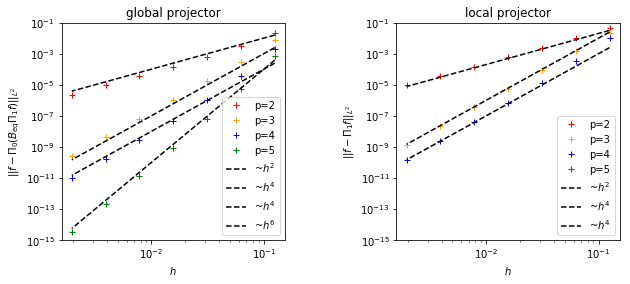

In [26]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(4)


plt.subplot(1, 2, 1)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_glob[ip], 'k+', color=colors[ip], label=labels[ip])
  
    
plt.loglog(hs[0],     hs[0]**2, 'k--', label='~$h^2$')
plt.loglog(hs[0], 1e1*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0],     hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 1e2*hs[0]**6, 'k--', label='~$h^6$')

plt.xlabel('$h$')
plt.ylabel('$||f-\Pi_0(B_\mathrm{eq}\Pi_1f)||_{L^2}$')
plt.title('global projector')
plt.ylim((1e-15, 1e-1))
plt.legend()


plt.subplot(1, 2, 2)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_loc[ip], 'k+', color=colors[ip], label=labels[ip])

plt.loglog(hs[0], 0.2e1*hs[0]**2, 'k--', label='~$h^2$')
plt.loglog(hs[0],   1e2*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0],   1e1*hs[0]**4, 'k--', label='~$h^4$')

plt.xlabel('$h$')
plt.ylabel('$||f-\Pi_1f||_{L^2}$')
plt.title('local projector')
plt.ylim((1e-15, 1e-1))
plt.legend()

plt.subplots_adjust(wspace=0.5)

# 5. $L^2-$ projection of an advective term (weak)

We want to approximate the function $f(x) = a(x)\frac{\mathrm{d}B}{\mathrm{d}x}$ with $B\in L^2$ using a $L^2-$projection: find $f_h\in V_0$ such that

$$
(f-f_h,c_h)=0 \qquad\forall c_h\in V_0, \\
\Leftrightarrow \int_0^1 f_h(x)c_h(x)\mathrm{d}x=\int_0^1 a(x)\frac{\mathrm{d}B}{\mathrm{d}x}c_h(x)\mathrm{d}x=-\int_0^1 B(x)\frac{\mathrm{d}}{\mathrm{d}x}[a(x)c_h(x)]\mathrm{d}x + \mathrm{b.c.}\qquad\forall c_h\in V_0. \\
$$

We assume that $B$ is given by an approximation $B_h\in V_1$, $a$ is a known continuous field representing for instance an equilibrium quantitiy or a material property and the boundary term in the integration by parts step vanishes. We can compute the right-hand side in two different ways. Either we leave it as it is,

$$
-\int_0^1 B_h(x)\frac{\mathrm{d}}{\mathrm{d}x}[a(x)c_h(x)]\mathrm{d}x=-\sum_{ij}c_ib_j\int_0^1\left(\frac{\mathrm{d}a}{\mathrm{d}x}\varphi^0_i(x)+a(x)\frac{\mathrm{d}\varphi_i^0(x)}{\mathrm{d}x}\right)\varphi^1_j(x)\mathrm{d}x=:-\mathbf{c}^\top(\mathbb{A} + \mathbb{K})\mathbf{b} \qquad \forall\mathbf{c}\in\mathbb{R}^N,
$$

or we project the term $a(x)c_h(x)\notin V_0$ back into $V_0$:

$$
-\int_0^1 B_h(x)\frac{\mathrm{d}}{\mathrm{d}x}\Pi_0[a(x)c_h(x)]\mathrm{d}x=-\sum_{ij}b_ic_j\int_0^1 \varphi^1_i(x)\frac{\mathrm{d}}{\mathrm{d}x}\Pi_0[a(x)\varphi^0_j(x)]\mathrm{d}x=-\mathbf{b}^\top\mathbb{M}^1\mathbb{G}\mathcal{T}\mathbf{c}\qquad \forall\mathbf{c}\in\mathbb{R}^N.
$$

The matrix $\mathcal{T}_{ij}=\Pi_0^i(a(x)\varphi^0_j(x))$, i.e. it gives the i-th coefficient in the basis of $V_0$ of the j-th weighted basis function $a(x)\varphi^0_j(x)$.

Hence we get the two set of coefficients

$$
\mathbf{f}^\mathrm{ref}=-\mathbb{M}_0^{-1}(\mathbb{A}+\mathbb{K})\mathbf{b}, \\
\mathbf{f}=-\mathbb{M}_0^{-1}\mathcal{T}^\top\mathbb{G}^\top\mathbb{M}^1\mathbf{b},
$$

whose difference we can measure in the $L^2$-norm

$$
||f_h^\mathrm{ref}-f_h||^2_{L^2} = \int_0^1(f_h^\mathrm{ref}-f_h)^2\mathrm{d}x=(\mathbf{f}^\mathrm{ref} - \mathbf{f})^\top\mathbb{M}_0(\mathbf{f}^\mathrm{ref} - \mathbf{f}),
$$

as we refine the mesh. Additionally, we can check the convergence of the two methods separately.

In [34]:
# =============================================== A matrix in V0/V1 (ND) (1d) =============================================
def A_mat(spline_space, d_fun):
    
    p      = spline_space.p       # spline degrees
    Nel    = spline_space.Nel     # number of elements
    NbaseN = spline_space.NbaseN  # total number of basis functions (N)
    NbaseD = spline_space.NbaseD  # total number of basis functions (D)
    
    n_quad = spline_space.n_quad  # number of quadrature points per element
    pts    = spline_space.pts     # global quadrature points in format (element, local quad_point)
    wts    = spline_space.wts     # global quadrature weights in format (element, local weight)
    
    basisN = spline_space.basisN  # evaluated basis functions at quadrature points (N)
    basisD = spline_space.basisD  # evaluated basis functions at quadrature points (D)
    
    # assembly
    M = np.zeros((NbaseN, 2*p + 1), dtype=float)

    for ie in range(Nel):

        for il in range(p + 1):
            for jl in range(p):

                value = 0.

                for q in range(n_quad):
                    value += wts[ie, q] * basisN[ie, il, 0, q] * basisD[ie, jl, 0, q] * d_fun(pts[ie, q])

                M[(ie + il)%NbaseN, p + jl - il] += value
                
    
    indices = np.indices((NbaseN, 2*p + 1))
    shift   = np.arange(NbaseN) - p

    row     = indices[0].flatten()
    col     = (indices[1] + shift[:, None])%NbaseD
    
    M       = spa.csr_matrix((M.flatten(), (row, col.flatten())), shape=(NbaseN, NbaseD))
    M.eliminate_zeros()
                
    return M
# ============================================================================================================================



# =============================================== K matrix in V0/V1 (ND) (1d) =============================================
def K_mat(spline_space, fun):
    
    p      = spline_space.p       # spline degrees
    Nel    = spline_space.Nel     # number of elements
    NbaseN = spline_space.NbaseN  # total number of basis functions (N)
    NbaseD = spline_space.NbaseD  # total number of basis functions (D)
    
    n_quad = spline_space.n_quad  # number of quadrature points per element
    pts    = spline_space.pts     # global quadrature points in format (element, local quad_point)
    wts    = spline_space.wts     # global quadrature weights in format (element, local weight)
    
    # evaluated basis functions at quadrature points (D)
    basisD = spline_space.basisD  
    
    # evaluated basis functions with first derivative at quadrature points (N)
    basisN = bsp.basis_ders_on_quad_grid(spline_space.T, p, pts, 1, normalize=False)
    
    # assembly
    M = np.zeros((NbaseN, 2*p + 1), dtype=float)

    for ie in range(Nel):

        for il in range(p + 1):
            for jl in range(p):

                value = 0.

                for q in range(n_quad):
                    value += wts[ie, q] * basisN[ie, il, 1, q] * basisD[ie, jl, 0, q] * fun(pts[ie, q])

                M[(ie + il)%NbaseN, p + jl - il] += value
                
    
    indices = np.indices((NbaseN, 2*p + 1))
    shift   = np.arange(NbaseN) - p

    row     = indices[0].flatten()
    col     = (indices[1] + shift[:, None])%NbaseD
    
    M       = spa.csr_matrix((M.flatten(), (row, col.flatten())), shape=(NbaseN, NbaseD))
    M.eliminate_zeros()
                
    return M
# ============================================================================================================================

## 5. 1 Smooth a(x)

In [38]:
# test of both methods work for single set of parameters
Nel       = 64                           # number of elements   
bc        = True                         # boundary conditions (True: periodic, False: else)
p         = 3                            # spline degres

nq_el     = p + 1                        # number of quadrature points per element for integrations over whole domain
nq_pr     = p + 1                        # number of quadrature points per integration interval of projectors

el_b      = np.linspace(0., 1., Nel + 1) # element boundaries
T         = bsp.make_knots(el_b, p, bc)  # knot vector (for N functions)

# 1d B-spline finite element space
space     = spl.spline_space_1d(T, p, bc, nq_el)


NbaseN = space.NbaseN
NbaseD = space.NbaseD

xplot = np.linspace(0., 1., 200)

# projectors
proj_glob = proj_global.projectors_1d(T, p, bc)
proj_loc  = proj_local.projectors_local_1d(space, nq_pr)

# assemble interpolation and histopolation matrix for global projector
proj_glob.assemble_V0()
proj_glob.assemble_V1()

In [39]:
Bh     = lambda x :  np.sin(2*np.pi*x)
dBh    = lambda x :  np.cos(2*np.pi*x)*2*np.pi

omega  = 6.
a      = lambda x :  np.cos(omega*np.pi*x)
da     = lambda x : -np.sin(omega*np.pi*x)*omega*np.pi


result = lambda x : a(x)*dBh(x)

b_coeff_glob = proj_glob.PI_1(Bh)
b_coeff_loc  = proj_loc.pi_1(Bh)

A = A_mat(space, da)
K = K_mat(space, a)

M0 = mass.mass_V0(space, lambda x : np.ones(x.shape))
M1 = mass.mass_V1(space, lambda x : np.ones(x.shape))
G  = der.grad_1d(space)

tau_glob = np.zeros((NbaseN, NbaseN))
tau_loc  = np.zeros((NbaseN, NbaseN))

N = bspline.Bspline(T, p)
D = bspline.Bspline(t, p - 1) 

for j in range(NbaseN):
    
    if j < p:
        fun = lambda x : a(x) * (N(x, j) + N(x, NbaseN + j ))
    else:
        fun = lambda x : a(x) *  N(x, j)
    
    tau_glob[:, j] = proj_glob.PI_0(fun)
    tau_loc[:, j] = proj_loc.pi_0(fun)

L2 error method 1: global projector 5.040165112167538e-05
L2 error method 1: local projector 5.0458136333638054e-05
L2 error method 2: global projector 9.089233465043832e-05
L2 error method 2: local projector 0.0004562456722374067


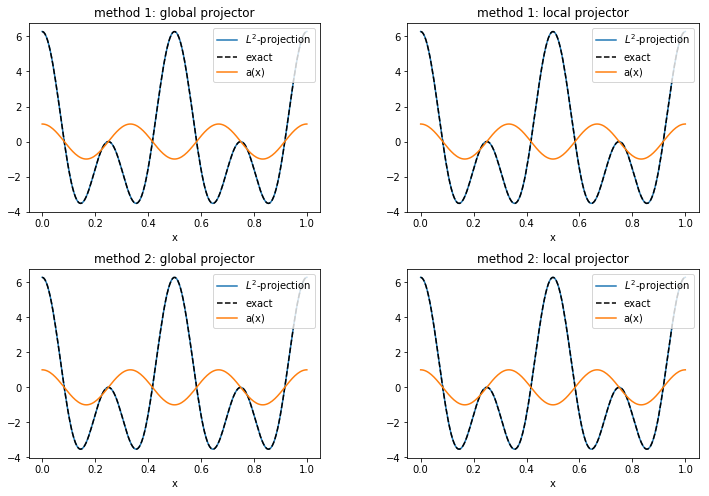

In [43]:
coeff1_glob = np.linalg.solve(M0.toarray(), -(A + K).dot(b_coeff_glob))
coeff1_loc  = np.linalg.solve(M0.toarray(), -(A + K).dot(b_coeff_loc))

coeff2_glob = np.linalg.solve(M0.toarray(), -tau_glob.T.dot(G.T.dot(M1.dot(b_coeff_glob))))
coeff2_loc  = np.linalg.solve(M0.toarray(), -tau_loc.T.dot(G.T.dot(M1.dot(b_coeff_loc))))


fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(8)

plt.subplot(2, 2, 1)

res_glob = space.evaluate_0form(coeff1_glob, xplot)
res_loc  = space.evaluate_0form(coeff1_loc, xplot)

plt.plot(xplot, res_glob, label='$L^2$-projection')
plt.plot(xplot, result(xplot), 'k--', label='exact')
plt.plot(xplot, a(xplot), label='a(x)')
plt.xlabel('x')
plt.title('method 1: global projector')
plt.legend()

plt.subplot(2, 2, 2)

plt.plot(xplot, res_loc, label='$L^2$-projection')
plt.plot(xplot, result(xplot), 'k--', label='exact')
plt.plot(xplot, a(xplot), label='a(x)')
plt.xlabel('x')
plt.title('method 1: local projector')
plt.legend()


plt.subplot(2, 2, 3)

res_glob = space.evaluate_0form(coeff2_glob, xplot)
res_loc  = space.evaluate_0form(coeff2_loc, xplot)

plt.plot(xplot, res_glob, label='$L^2$-projection')
plt.plot(xplot, result(xplot), 'k--', label='exact')
plt.plot(xplot, a(xplot), label='a(x)')
plt.xlabel('x')
plt.title('method 2: global projector')
plt.legend()

plt.subplot(2, 2, 4)

plt.plot(xplot, res_loc, label='$L^2$-projection')
plt.plot(xplot, result(xplot), 'k--', label='exact')
plt.plot(xplot, a(xplot), label='a(x)')
plt.xlabel('x')
plt.title('method 2: local projector')
plt.legend()

plt.subplots_adjust(wspace=0.3, hspace=0.3)

# L2 - errors
print('L2 error method 1: global projector', l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff1_glob, result))
print('L2 error method 1: local projector', l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff1_loc, result))
print('L2 error method 2: global projector', l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff2_glob, result))
print('L2 error method 2: local projector', l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff2_loc, result))

In [44]:
# covergence test
Nels   = np.array([8, 16, 32, 64, 128, 256, 512, 1024])
ps     = np.array([2, 3, 4])

hs     = np.zeros((len(ps), len(Nels)))

errors_meth1_glob = np.zeros((len(ps), len(Nels)))
errors_meth1_loc  = np.zeros((len(ps), len(Nels)))

errors_meth2_glob = np.zeros((len(ps), len(Nels)))
errors_meth2_loc  = np.zeros((len(ps), len(Nels)))

errors_diff_glob  = np.zeros((len(ps), len(Nels)))
errors_diff_loc   = np.zeros((len(ps), len(Nels)))


for ip in range(len(ps)):
    for ie in range(len(Nels)):

        Nel        = Nels[ie]                      # number of elements   
        bc         = True                          # boundary conditions (True: periodic, False: else)
        p          = int(ps[ip])                   # spline degres  

        el_b       = np.linspace(0., 1., Nel + 1)  # element boundaries
        T          = bsp.make_knots(el_b, p, bc)   # knot vector (for N functions)
        
        nq_el      = p + 1                         # number of quadrature points per element for integrations over whole domain
        nq_pr      = p + 1                         # number of quadrature points per integration interval for projectors
        
        # 1d B-spline finite element space
        space      = spl.spline_space_1d(T, p, bc, nq_el) 
        
        hs[ip, ie] = space.delta                   # element size
        t          = space.t                       # reduced knot vector (for D functions)
        NbaseN     = space.NbaseN                  # number of basis functions (N functions)
        NbaseD     = space.NbaseD                  # number of basis functions (D functions)
        
        # projectors
        proj_glob = proj_global.projectors_1d(T, p, bc)
        proj_loc  = proj_local.projectors_local_1d(space, nq_pr)

        # assemble interpolation and histopolation matrix for global projector
        proj_glob.assemble_V0()
        proj_glob.assemble_V1()
        
        b_coeff_glob = proj_glob.PI_1(Bh)
        b_coeff_loc = proj_loc.pi_1(Bh)

        A = A_mat(space, da)
        K = K_mat(space, a)

        M0 = mass.mass_V0(space, lambda x : np.ones(x.shape))
        M1 = mass.mass_V1(space, lambda x : np.ones(x.shape))
        G  = der.grad_1d(space)

        tau_glob = np.zeros((NbaseN, NbaseN))
        tau_loc  = np.zeros((NbaseN, NbaseN))

        N = bspline.Bspline(T, p)
        D = bspline.Bspline(t, p - 1) 

        for j in range(NbaseN):

            if j < p:
                fun = lambda x : a(x) * (N(x, j) + N(x, NbaseN + j ))
            else:
                fun = lambda x : a(x) *  N(x, j)

            tau_glob[:, j] = proj_glob.PI_0(fun)
            tau_loc[:, j] = proj_loc.pi_0(fun)
            
        
        coeff1_glob = np.linalg.solve(M0.toarray(), -(A + K).dot(b_coeff_glob))
        coeff1_loc = np.linalg.solve(M0.toarray(), -(A + K).dot(b_coeff_loc))
        
        coeff2_glob = np.linalg.solve(M0.toarray(), -tau_glob.T.dot(G.T.dot(M1.dot(b_coeff_glob))))
        coeff2_loc = np.linalg.solve(M0.toarray(), -tau_loc.T.dot(G.T.dot(M1.dot(b_coeff_loc))))
            
        errors_meth1_glob[ip, ie] = l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff1_glob, result)
        errors_meth1_loc[ip, ie] = l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff1_loc, result)
        
        errors_meth2_glob[ip, ie] = l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff2_glob, result)
        errors_meth2_loc[ip, ie] = l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff2_loc, result)
        
        errors_diff_glob[ip, ie] = np.sqrt((coeff1_glob - coeff2_glob).dot(M0.dot(coeff1_glob - coeff2_glob)))
        errors_diff_loc[ip, ie] = np.sqrt((coeff1_loc - coeff2_loc).dot(M0.dot(coeff1_loc - coeff2_loc)))

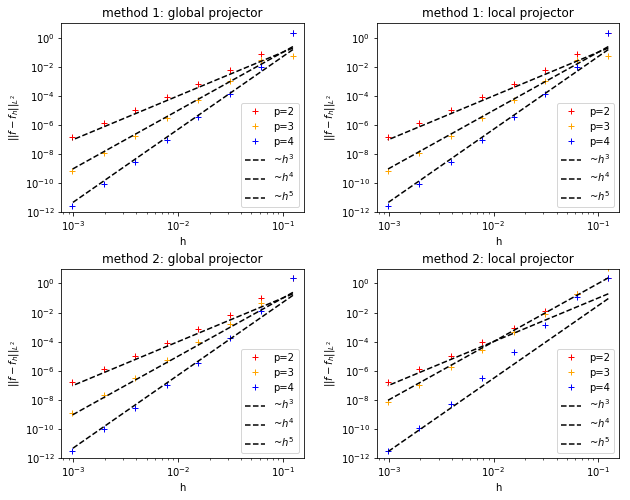

In [45]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']


fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(8)


plt.subplot(2, 2, 1)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_meth1_glob[ip], '+', color = colors[ip], label=labels[ip])
    
plt.loglog(hs[0], 1e2*hs[0]**3, 'k--', label='~$h^3$')
plt.loglog(hs[0], 1e3*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 5e3*hs[0]**5, 'k--', label='~$h^5$')

plt.xlabel('h')
plt.ylabel('$||f-f_h||_{L^2}$')
plt.title('method 1: global projector')
plt.ylim((1e-12, 1e1))
plt.legend()


plt.subplot(2, 2, 2)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_meth1_loc[ip], '+', color = colors[ip], label=labels[ip])
    
plt.loglog(hs[0], 1e2*hs[0]**3, 'k--', label='~$h^3$')
plt.loglog(hs[0], 1e3*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 5e3*hs[0]**5, 'k--', label='~$h^5$')

plt.xlabel('h')
plt.ylabel('$||f-f_h||_{L^2}$')
plt.title('method 1: local projector')
plt.ylim((1e-12, 1e1))
plt.legend()


plt.subplot(2, 2, 3)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_meth2_glob[ip], '+', color = colors[ip], label=labels[ip])
    
plt.loglog(hs[0], 1e2*hs[0]**3, 'k--', label='~$h^3$')
plt.loglog(hs[0], 1e3*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 5e3*hs[0]**5, 'k--', label='~$h^5$')

plt.xlabel('h')
plt.ylabel('$||f-f_h||_{L^2}$')
plt.title('method 2: global projector')
plt.ylim((1e-12, 1e1))
plt.legend()


plt.subplot(2, 2, 4)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_meth2_loc[ip], '+', color = colors[ip], label=labels[ip])
    
plt.loglog(hs[0], 1e2*hs[0]**3, 'k--', label='~$h^3$')
plt.loglog(hs[0], 1e4*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 3e3*hs[0]**5, 'k--', label='~$h^5$')

plt.xlabel('h')
plt.ylabel('$||f-f_h||_{L^2}$')
plt.title('method 2: local projector')
plt.ylim((1e-12, 1e1))
plt.legend()


plt.subplots_adjust(wspace=0.3, hspace=0.3)

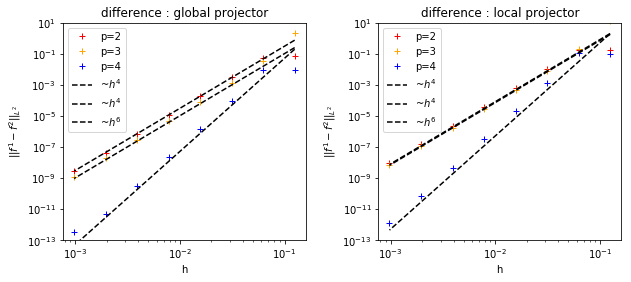

In [46]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']


fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(4)


plt.subplot(1, 2, 1)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_diff_glob[ip], '+', color = colors[ip], label=labels[ip])
    
plt.loglog(hs[0], 3e3*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 1e3*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 5e4*hs[0]**6, 'k--', label='~$h^6$')

plt.xlabel('h')
plt.ylabel('$||f^1-f^2||_{L^2}$')
plt.title('difference : global projector')
plt.ylim((1e-13, 1e1))
plt.legend()


plt.subplot(1, 2, 2)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_diff_loc[ip], '+', color = colors[ip], label=labels[ip])
    
plt.loglog(hs[0], 8e3*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 7e3*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 5e5*hs[0]**6, 'k--', label='~$h^6$')

plt.xlabel('h')
plt.ylabel('$||f^1-f^2||_{L^2}$')
plt.title('difference : local projector')
plt.ylim((1e-13, 1e1))
plt.legend()

plt.subplots_adjust(wspace=0.3)

## 5. 2 Non - smooth a(x)

In [50]:
# test of both methods work for single set of parameters
Nel       = 128                           # number of elements   
bc        = True                         # boundary conditions (True: periodic, False: else)
p         = 3                            # spline degres

nq_el     = p + 1                        # number of quadrature points per element for integrations over whole domain
nq_pr     = p + 1                        # number of quadrature points per integration interval of projectors

el_b      = np.linspace(0., 1., Nel + 1) # element boundaries
T         = bsp.make_knots(el_b, p, bc)  # knot vector (for N functions)

# 1d B-spline finite element space
space     = spl.spline_space_1d(T, p, bc, nq_el)


NbaseN = space.NbaseN
NbaseD = space.NbaseD

xplot = np.linspace(0., 1., 200)

# projectors
proj_glob = proj_global.projectors_1d(T, p, bc)
proj_loc  = proj_local.projectors_local_1d(space, nq_pr)

# assemble interpolation and histopolation matrix for global projector
proj_glob.assemble_V0()
proj_glob.assemble_V1()

In [51]:
Bh     = lambda x :  np.sin(2*np.pi*x)
dBh    = lambda x :  np.cos(2*np.pi*x)*2*np.pi

omega  = 6.

a     = lambda x :  np.abs(np.cos(omega*np.pi*(x - 0.1)))
da    = lambda x : -np.sin(omega*np.pi*(x - 0.1))*omega*np.pi*np.cos(omega*np.pi*(x - 0.1))/np.abs(np.cos(omega*np.pi*(x - 0.1)))

result = lambda x : a(x)*dBh(x)

b_coeff_glob = proj_glob.PI_1(Bh)
b_coeff_loc  = proj_loc.pi_1(Bh)

A = A_mat(space, da)
K = K_mat(space, a)

M0 = mass.mass_V0(space, lambda x : np.ones(x.shape))
M1 = mass.mass_V1(space, lambda x : np.ones(x.shape))
G  = der.grad_1d(space)

tau_glob = np.zeros((NbaseN, NbaseN))
tau_loc  = np.zeros((NbaseN, NbaseN))

N = bspline.Bspline(T, p)
D = bspline.Bspline(t, p - 1) 

for j in range(NbaseN):
    
    if j < p:
        fun = lambda x : a(x) * (N(x, j) + N(x, NbaseN + j ))
    else:
        fun = lambda x : a(x) *  N(x, j)
    
    tau_glob[:, j] = proj_glob.PI_0(fun)
    tau_loc[:, j] = proj_loc.pi_0(fun)

L2 error method 1: global projector 0.19854158623411153
L2 error method 1: local projector 0.1985415781390331
L2 error method 2: global projector 0.02262455418828196
L2 error method 2: local projector 0.11578412851887547


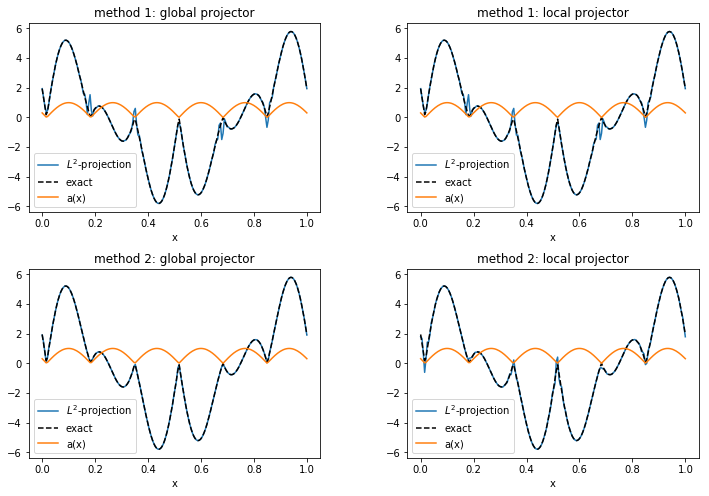

In [52]:
coeff1_glob = np.linalg.solve(M0.toarray(), -(A + K).dot(b_coeff_glob))
coeff1_loc  = np.linalg.solve(M0.toarray(), -(A + K).dot(b_coeff_loc))

coeff2_glob = np.linalg.solve(M0.toarray(), -tau_glob.T.dot(G.T.dot(M1.dot(b_coeff_glob))))
coeff2_loc  = np.linalg.solve(M0.toarray(), -tau_loc.T.dot(G.T.dot(M1.dot(b_coeff_loc))))


fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(8)

plt.subplot(2, 2, 1)

res_glob = space.evaluate_0form(coeff1_glob, xplot)
res_loc  = space.evaluate_0form(coeff1_loc, xplot)

plt.plot(xplot, res_glob, label='$L^2$-projection')
plt.plot(xplot, result(xplot), 'k--', label='exact')
plt.plot(xplot, a(xplot), label='a(x)')
plt.xlabel('x')
plt.title('method 1: global projector')
plt.legend()

plt.subplot(2, 2, 2)

plt.plot(xplot, res_loc, label='$L^2$-projection')
plt.plot(xplot, result(xplot), 'k--', label='exact')
plt.plot(xplot, a(xplot), label='a(x)')
plt.xlabel('x')
plt.title('method 1: local projector')
plt.legend()


plt.subplot(2, 2, 3)

res_glob = space.evaluate_0form(coeff2_glob, xplot)
res_loc  = space.evaluate_0form(coeff2_loc, xplot)

plt.plot(xplot, res_glob, label='$L^2$-projection')
plt.plot(xplot, result(xplot), 'k--', label='exact')
plt.plot(xplot, a(xplot), label='a(x)')
plt.xlabel('x')
plt.title('method 2: global projector')
plt.legend()

plt.subplot(2, 2, 4)

plt.plot(xplot, res_loc, label='$L^2$-projection')
plt.plot(xplot, result(xplot), 'k--', label='exact')
plt.plot(xplot, a(xplot), label='a(x)')
plt.xlabel('x')
plt.title('method 2: local projector')
plt.legend()

plt.subplots_adjust(wspace=0.3, hspace=0.3)

# L2 - errors
print('L2 error method 1: global projector', l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff1_glob, result))
print('L2 error method 1: local projector', l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff1_loc, result))
print('L2 error method 2: global projector', l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff2_glob, result))
print('L2 error method 2: local projector', l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff2_loc, result))

In [53]:
# covergence test
Nels   = np.array([8, 16, 32, 64, 128, 256, 512, 1024])
ps     = np.array([2, 3, 4])

hs     = np.zeros((len(ps), len(Nels)))

errors_meth1_glob = np.zeros((len(ps), len(Nels)))
errors_meth1_loc  = np.zeros((len(ps), len(Nels)))

errors_meth2_glob = np.zeros((len(ps), len(Nels)))
errors_meth2_loc  = np.zeros((len(ps), len(Nels)))

errors_diff_glob  = np.zeros((len(ps), len(Nels)))
errors_diff_loc   = np.zeros((len(ps), len(Nels)))


for ip in range(len(ps)):
    for ie in range(len(Nels)):

        Nel        = Nels[ie]                      # number of elements   
        bc         = True                          # boundary conditions (True: periodic, False: else)
        p          = int(ps[ip])                   # spline degres  

        el_b       = np.linspace(0., 1., Nel + 1)  # element boundaries
        T          = bsp.make_knots(el_b, p, bc)   # knot vector (for N functions)
        
        nq_el      = p + 1                         # number of quadrature points per element for integrations over whole domain
        nq_pr      = p + 1                         # number of quadrature points per integration interval for projectors
        
        # 1d B-spline finite element space
        space      = spl.spline_space_1d(T, p, bc, nq_el) 
        
        hs[ip, ie] = space.delta                   # element size
        t          = space.t                       # reduced knot vector (for D functions)
        NbaseN     = space.NbaseN                  # number of basis functions (N functions)
        NbaseD     = space.NbaseD                  # number of basis functions (D functions)
        
        # projectors
        proj_glob = proj_global.projectors_1d(T, p, bc)
        proj_loc  = proj_local.projectors_local_1d(space, nq_pr)

        # assemble interpolation and histopolation matrix for global projector
        proj_glob.assemble_V0()
        proj_glob.assemble_V1()
        
        b_coeff_glob = proj_glob.PI_1(Bh)
        b_coeff_loc = proj_loc.pi_1(Bh)

        A = A_mat(space, da)
        K = K_mat(space, a)

        M0 = mass.mass_V0(space, lambda x : np.ones(x.shape))
        M1 = mass.mass_V1(space, lambda x : np.ones(x.shape))
        G  = der.grad_1d(space)

        tau_glob = np.zeros((NbaseN, NbaseN))
        tau_loc  = np.zeros((NbaseN, NbaseN))

        N = bspline.Bspline(T, p)
        D = bspline.Bspline(t, p - 1) 

        for j in range(NbaseN):

            if j < p:
                fun = lambda x : a(x) * (N(x, j) + N(x, NbaseN + j ))
            else:
                fun = lambda x : a(x) *  N(x, j)

            tau_glob[:, j] = proj_glob.PI_0(fun)
            tau_loc[:, j] = proj_loc.pi_0(fun)
            
        
        coeff1_glob = np.linalg.solve(M0.toarray(), -(A + K).dot(b_coeff_glob))
        coeff1_loc = np.linalg.solve(M0.toarray(), -(A + K).dot(b_coeff_loc))
        
        coeff2_glob = np.linalg.solve(M0.toarray(), -tau_glob.T.dot(G.T.dot(M1.dot(b_coeff_glob))))
        coeff2_loc = np.linalg.solve(M0.toarray(), -tau_loc.T.dot(G.T.dot(M1.dot(b_coeff_loc))))
            
        errors_meth1_glob[ip, ie] = l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff1_glob, result)
        errors_meth1_loc[ip, ie] = l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff1_loc, result)
        
        errors_meth2_glob[ip, ie] = l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff2_glob, result)
        errors_meth2_loc[ip, ie] = l2.l2_error_V0(space, lambda x : np.ones(x.shape), coeff2_loc, result)
        
        errors_diff_glob[ip, ie] = np.sqrt((coeff1_glob - coeff2_glob).dot(M0.dot(coeff1_glob - coeff2_glob)))
        errors_diff_loc[ip, ie] = np.sqrt((coeff1_loc - coeff2_loc).dot(M0.dot(coeff1_loc - coeff2_loc)))

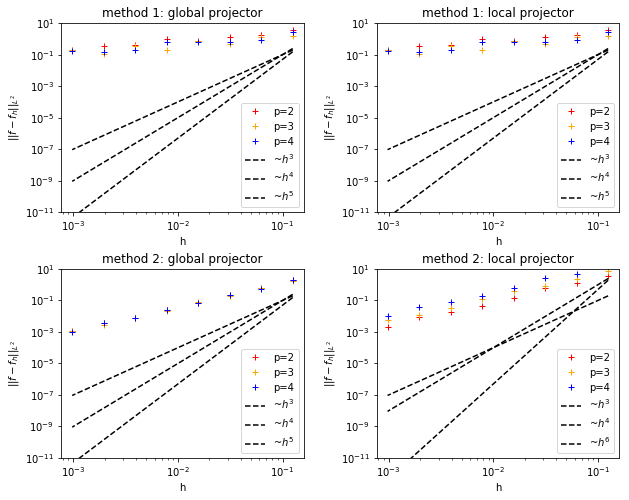

In [54]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']


fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(8)


plt.subplot(2, 2, 1)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_meth1_glob[ip], '+', color = colors[ip], label=labels[ip])
    
plt.loglog(hs[0], 1e2*hs[0]**3, 'k--', label='~$h^3$')
plt.loglog(hs[0], 1e3*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 5e3*hs[0]**5, 'k--', label='~$h^5$')

plt.xlabel('h')
plt.ylabel('$||f-f_h||_{L^2}$')
plt.title('method 1: global projector')
plt.ylim((1e-11, 1e1))
plt.legend()


plt.subplot(2, 2, 2)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_meth1_loc[ip], '+', color = colors[ip], label=labels[ip])
    
plt.loglog(hs[0], 1e2*hs[0]**3, 'k--', label='~$h^3$')
plt.loglog(hs[0], 1e3*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 5e3*hs[0]**5, 'k--', label='~$h^5$')

plt.xlabel('h')
plt.ylabel('$||f-f_h||_{L^2}$')
plt.title('method 1: local projector')
plt.ylim((1e-11, 1e1))
plt.legend()


plt.subplot(2, 2, 3)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_meth2_glob[ip], '+', color = colors[ip], label=labels[ip])
    
plt.loglog(hs[0], 1e2*hs[0]**3, 'k--', label='~$h^3$')
plt.loglog(hs[0], 1e3*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 5e3*hs[0]**5, 'k--', label='~$h^5$')

plt.xlabel('h')
plt.ylabel('$||f-f_h||_{L^2}$')
plt.title('method 2: global projector')
plt.ylim((1e-11, 1e1))
plt.legend()


plt.subplot(2, 2, 4)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_meth2_loc[ip], '+', color = colors[ip], label=labels[ip])
    
plt.loglog(hs[0], 1e2*hs[0]**3, 'k--', label='~$h^3$')
plt.loglog(hs[0], 1e4*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 5e5*hs[0]**6, 'k--', label='~$h^6$')

plt.xlabel('h')
plt.ylabel('$||f-f_h||_{L^2}$')
plt.title('method 2: local projector')
plt.ylim((1e-11, 1e1))
plt.legend()


plt.subplots_adjust(wspace=0.3, hspace=0.3)

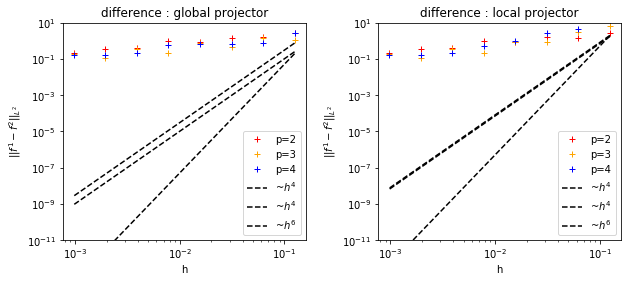

In [55]:
colors = ['red', 'orange', 'blue', 'green']
labels = ['p=2', 'p=3', 'p=4', 'p=5']


fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(4)


plt.subplot(1, 2, 1)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_diff_glob[ip], '+', color = colors[ip], label=labels[ip])
    
plt.loglog(hs[0], 3e3*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 1e3*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 5e4*hs[0]**6, 'k--', label='~$h^6$')

plt.xlabel('h')
plt.ylabel('$||f^1-f^2||_{L^2}$')
plt.title('difference : global projector')
plt.ylim((1e-11, 1e1))
plt.legend()


plt.subplot(1, 2, 2)

for ip in range(len(ps)):
    plt.loglog(hs[ip], errors_diff_loc[ip], '+', color = colors[ip], label=labels[ip])
    
plt.loglog(hs[0], 8e3*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 7e3*hs[0]**4, 'k--', label='~$h^4$')
plt.loglog(hs[0], 5e5*hs[0]**6, 'k--', label='~$h^6$')

plt.xlabel('h')
plt.ylabel('$||f^1-f^2||_{L^2}$')
plt.title('difference : local projector')
plt.ylim((1e-11, 1e1))
plt.legend()

plt.subplots_adjust(wspace=0.3)